In [1]:
import pandas as pd
import numpy as np
import re
import requests
import datetime
import os
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import ambiance

In [2]:
def read_xls(file, sheet):
    
    try:
        df = pd.read_excel(file,sheet)
    except FileNotFoundError as e:
        print("Excel file not found " + str(e))
        sys.exit(1)
    
    return df

In [3]:
def read_csv(file):
    
    try:
        df = pd.read_csv(file, sep=' ')
    except FileNotFoundError as e:
        print("Excel file not found " + str(e))
        sys.exit(1)
    
    return df

In [4]:
def calculate_bearing(d):
  dirs = ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW']
  ix = int(round(d / (360. / len(dirs))))
    
  return dirs[ix % len(dirs)]

In [5]:
def convert_lat_gps_coord(coor):
    
    lat_deg = coor[:2]
    lat_min = coor[2:4]
    lat_sec = coor[5:7]
    direction = coor[7]
    
    dd = (float(lat_deg) + float(lat_min)/60 + float(lat_sec)/(60*60)) * (-1 if direction in ['W', 'S'] else 1)

    return dd

In [6]:
def convert_lon_gps_coord(coor):
    
    lon_deg = coor[1:3]
    lon_min = coor[3:5]
    lon_sec = coor[6:8]
    direction = coor[8]
    
    dd = (float(lon_deg) + float(lon_min)/60 + float(lon_sec)/(60*60)) * (-1 if direction in ['W', 'S'] else 1)
    
    return dd

In [7]:
def plot(lat, lng, zoom=10, map_type='roadmap'):
    gmap_options = GMapOptions(lat=lat, lng=lng, 
                               map_type=map_type, zoom=zoom)
    p = gmap(api_key, gmap_options, title='Pays de Gex', 
             width=bokeh_width, height=bokeh_height)
    # definition of the column data source: 
    source = ColumnDataSource(df)
    # see how we specify the x and y columns as strings, 
    # and how to declare as a source the ColumnDataSource:
    center = p.circle('lon', 'lat', size=4, alpha=0.2, 
                      color='yellow', source=source)
    show(p)
    return p

In [8]:
def Alt_toPressure(val):

    return ambiance.Atmosphere(val).pressure[0]

In [9]:
def Alt_toTemp(val):
    
    return ambiance.Atmosphere.T2t(ambiance.Atmosphere(val).temperature)[0]

In [10]:
def Alt_toLayerName(val):
    
    return ambiance.Atmosphere(val).layer_name[0]

In [11]:
def Pressure_toAlt(val):

    return ambiance.Atmosphere.from_pressure(val).h[0]

In [12]:
def Pressure_toTemp(val):
    
    return ambiance.Atmosphere.T2t(ambiance.Atmosphere.from_pressure(val).temperature)[0]

In [13]:
def Clean_Pressure(val):

    # Remove bad data
    if val > 200000:
        return np.nan
    return val

### Read Input Telemetry Spreadsheet

In [15]:
df = read_xls("KB9SAT-13.xlsx","KB9SAT-13")

In [16]:
df.sample(10)

Date      Time    TZ   
137 2023-04-28  10:48:08  CDT:  \
118 2023-04-28  10:31:56  CDT:   
9   2023-04-28  09:20:50  CDT:   
124 2023-04-28  10:38:25  CDT:   
69  2023-04-28  10:01:27  CDT:   
7   2023-04-28  09:19:15  CDT:   
47  2023-04-28  09:45:47  CDT:   
58  2023-04-28  09:52:33  CDT:   
102 2023-04-28  10:21:53  CDT:   
141 2023-04-28  10:50:43  CDT:   

                                                  Path       HDOP   
137  KB9SAT-13>APLIGA,WIDE2-1,qAR,KC8RFE-2:/154802h...     00127H  \
118        KB9SAT-13>APLIGA,WIDE2-1,qAR,KB0WLF-10:>1st       Hour   
9               KB9SAT-13>APLIGA,WIDE2-1,qAO,KS9A-10:>      6.01V   
124  KB9SAT-13>APLIGA,WIDE2-1,qAR,KX9A-1:/153819h40...     00129H   
69       KB9SAT-13>APLIGA,WIDE2-1,qAR,KC8RFE-3:>Normal  Community   
7    KB9SAT-13>APLIGA,W9AZ-1,WIDE2*,qAR,K9MQ-1:/141...     00097H   
47   KB9SAT-13>APLIGA,WIDE2-1,qAO,AB9JJ-10:/144541h...     00172H   
58   KB9SAT-13>APLIGA,WIDE2-1,qAO,KS9A-10:/145227h4...     00172H   
102         KB9SAT-13>APLIGA,WIDE2-1,qAR,NB9M-1:Normal  Community   
141                KB9SAT-13>APLIGA,WIDE2-1,qAR,W9PFD:      5.89V   

    Interior Temp (C) Interior Pressure       Name   Total TxC Telemetry TxC   
137             20.8C           178.hPa    Atlas-7         NaN           NaN  \
118                 -             Barry        the  Barometric       Balloon   
9                 07S            00104H  00000000F       0148T         0110T   
124             21.7C           148.hPa    Atlas-7         NaN           NaN   
69               High            School         IL        STEM           NaN   
7               43.4C           1496hPa    Atlas-7         NaN           NaN   
47              28.8C           439.hPa    Atlas-7         NaN           NaN   
58              24.9C           261.hPa    Atlas-7         NaN           NaN   
102              High            School         IL        STEM  [Unsupported   
141               06S            00135H  00000000F       0258T         0193T   

     ... Column14 Column15 Column16  Column17  Column18  Column19   
137  ...      NaN      NaN      NaN       NaN       NaN       NaN  \
118  ...      NaN      NaN      NaN       NaN       NaN       NaN   
9    ...      NaN      NaN      NaN       NaN       NaN       NaN   
124  ...      NaN      NaN      NaN       NaN       NaN       NaN   
69   ...      NaN      NaN      NaN       NaN       NaN       NaN   
7    ...      NaN      NaN      NaN       NaN       NaN       NaN   
47   ...      NaN      NaN      NaN       NaN       NaN       NaN   
58   ...      NaN      NaN      NaN       NaN       NaN       NaN   
102  ...      NaN      NaN      NaN       NaN       NaN       NaN   
141  ...      NaN      NaN      NaN       NaN       NaN       NaN   

         Column20  Column21  Column22 Column23  
137           NaN       NaN       NaN      NaN  
118           NaN       NaN       NaN      NaN  
9             NaN       NaN       NaN      NaN  
124           NaN       NaN       NaN      NaN  
69            NaN       NaN       NaN      NaN  
7             NaN       NaN       NaN      NaN  
47            NaN       NaN       NaN      NaN  
58            NaN       NaN       NaN      NaN  
102           NaN       NaN       NaN      NaN  
141  [Unsupported    packet   format]      NaN  

[10 rows x 23 columns]

In [17]:
df.columns

Index(['Date', 'Time', 'TZ', 'Path', 'HDOP', 'Interior Temp (C)',
       'Interior Pressure', 'Name', 'Total TxC', 'Telemetry TxC', 'Status TxC',
       'Name2', 'Column13', 'Column14', 'Column15', 'Column16', 'Column17',
       'Column18', 'Column19', 'Column20', 'Column21', 'Column22', 'Column23'],
      dtype='object')

In [18]:
# View large sample of df
df.head(15)

Date      Time    TZ   
0  2023-04-28  09:12:08  CDT:  \
1  2023-04-28  09:13:08  CDT:   
2  2023-04-28  09:14:09  CDT:   
3  2023-04-28  09:15:10  CDT:   
4  2023-04-28  09:16:11  CDT:   
5  2023-04-28  09:17:12  CDT:   
6  2023-04-28  09:18:13  CDT:   
7  2023-04-28  09:19:15  CDT:   
8  2023-04-28  09:20:15  CDT:   
9  2023-04-28  09:20:50  CDT:   
10 2023-04-28  09:20:50  CDT:   
11 2023-04-28  09:21:10  CDT:   
12 2023-04-28  09:21:10  CDT:   
13 2023-04-28  09:21:29  CDT:   
14 2023-04-28  09:21:29  CDT:   

                                                 Path       HDOP   
0   KB9SAT-13>APLIGA,WA9RES*,WIDE2-1,qAR,KC8RFE-2:...     00169H  \
1   KB9SAT-13>APLIGA,WIDE2-1,qAR,KC8RFE-3:/141302h...     00111H   
2   KB9SAT-13>APLIGA,WIDE2-1,qAR,KA3BQE:/141403h40...     00098H   
3   KB9SAT-13>APLIGA,WIDE2-1,qAR,KA3BQE:/141504h40...     00097H   
4   KB9SAT-13>APLIGA,WIDE2-1,qAO,KS9A-10:/141605h4...     00093H   
5   KB9SAT-13>APLIGA,WIDE2-1,qAO,KS9A-10:/141706h4...     00115H   
6   KB9SAT-13>APLIGA,WIDE2-1,qAR,KC8RFE-3:/141807h...     00248H   
7   KB9SAT-13>APLIGA,W9AZ-1,WIDE2*,qAR,K9MQ-1:/141...     00097H   
8   KB9SAT-13>APLIGA,WIDE2-1,qAR,WB9EOC-10:/142009...     00104H   
9              KB9SAT-13>APLIGA,WIDE2-1,qAO,KS9A-10:>      6.01V   
10                KB9SAT-13>APLIGA,WIDE2-1,qAR,W9PFD:      6.01V   
11      KB9SAT-13>APLIGA,WIDE2-1,qAR,KC8RFE-3:>Normal  Community   
12          KB9SAT-13>APLIGA,WIDE2-1,qAR,W9PFD:Normal  Community   
13         KB9SAT-13>APLIGA,WIDE2-1,qAR,KC8RFE-3:>1st       Hour   
14             KB9SAT-13>APLIGA,WIDE2-1,qAR,W9PFD:1st       Hour   

   Interior Temp (C) Interior Pressure       Name   Total TxC Telemetry TxC   
0              43.5C           1699hPa    Atlas-7         NaN           NaN  \
1              43.7C           1674hPa    Atlas-7         NaN           NaN   
2              43.7C           1648hPa    Atlas-7         NaN           NaN   
3              43.8C           1623hPa    Atlas-7         NaN           NaN   
4              43.7C           1590hPa    Atlas-7         NaN           NaN   
5              43.6C           1557hPa    Atlas-7         NaN           NaN   
6              43.5C           1526hPa    Atlas-7         NaN           NaN   
7              43.4C           1496hPa    Atlas-7         NaN           NaN   
8              43.1C           1461hPa    Atlas-7         NaN           NaN   
9                07S            00104H  00000000F       0148T         0110T   
10               07S            00104H  00000000F       0148T         0110T   
11              High            School         IL        STEM           NaN   
12              High            School         IL        STEM  [Unsupported   
13                 -             Barry        the  Barometric       Balloon   
14                 -             Barry        the  Barometric       Balloon   

    ... Column14 Column15 Column16  Column17  Column18  Column19   
0   ...      NaN      NaN      NaN       NaN       NaN       NaN  \
1   ...      NaN      NaN      NaN       NaN       NaN       NaN   
2   ...      NaN      NaN      NaN       NaN       NaN       NaN   
3   ...      NaN      NaN      NaN       NaN       NaN       NaN   
4   ...      NaN      NaN      NaN       NaN       NaN       NaN   
5   ...      NaN      NaN      NaN       NaN       NaN       NaN   
6   ...      NaN      NaN      NaN       NaN       NaN       NaN   
7   ...      NaN      NaN      NaN       NaN       NaN       NaN   
8   ...      NaN      NaN      NaN       NaN       NaN       NaN   
9   ...      NaN      NaN      NaN       NaN       NaN       NaN   
10  ...      NaN      NaN      NaN       NaN       NaN       NaN   
11  ...      NaN      NaN      NaN       NaN       NaN       NaN   
12  ...      NaN      NaN      NaN       NaN       NaN       NaN   
13  ...      NaN      NaN      NaN       NaN       NaN       NaN   
14  ...      NaN      NaN      NaN       NaN       NaN       NaN   

        Column20  Column21  Column22 

In [22]:
# Filter out telemetry from status messages (status message contain battery level)

df1 = pd.DataFrame(df[ df['HDOP'].str.endswith('V') == True ])
df2 = pd.DataFrame(df[ (df['HDOP'].str.contains('Community') == False) and (df['HDOP'].str.contains('Hour') == False) and (df['HDOP'].str.endswith('V') == True) ])
df3 = pd.DataFrame(df[ (df['HDOP'].str.contains('Community') == True) and (df['HDOP'].str.contains('Hour') == True) and (df['HDOP'].str.endswith('V') == False) ])

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [19]:
# Tracker Status
df1.head(5)

Date      Time    TZ                                          Path   
0  2022-05-13  08:46:42  CDT:  KW9D-12>APLIGA,N9ULL*,WIDE2-1,qAR,KC8RFE-3:>  \
4  2022-05-13  08:50:59  CDT:           KW9D-12>APLIGA,WIDE2*,qAO,KS9A-10:>   
9  2022-05-13  08:56:16  CDT:            KW9D-12>APLIGA,WIDE2-1,qAR,W9PFD:>   
16 2022-05-13  09:01:35  CDT:            KW9D-12>APLIGA,WIDE2-1,qAR,W9PFD:>   
21 2022-05-13  09:05:51  CDT:            KW9D-12>APLIGA,WIDE2-1,qAR,W9PFD:>   

     HDOP Interior Temp (C) Interior Pressure Exterior Temp (C)   
0   6.39V               08S            00128H         00000000F  \
4   6.40V               08S            00109H         00000000F   
9   6.43V               07S            00102H         00000000F   
16  6.43V               07S            00100H         00000000F   
21  6.47V               06S            00124H         00000000F   

   Exterior Pressure Humdity  ... Column17 Column18 Column19 Column20   
0              0033T   0023T  ...      NaN      NaN      NaN      NaN  \
4              0038T   0027T  ...      NaN      NaN      NaN      NaN   
9              0044T   0032T  ...      NaN      NaN      NaN      NaN   
16             0050T   0037T  ...      NaN      NaN      NaN      NaN   
21             0055T   0041T  ...      NaN      NaN      NaN      NaN   

    Column21 Column22  Column23  Column24 Column25 Column26  
0        NaN      NaN       NaN       NaN      NaN      NaN  
4        NaN      NaN       NaN       NaN      NaN      NaN  
9        NaN      NaN       NaN       NaN      NaN      NaN  
16       NaN      NaN       NaN       NaN      NaN      NaN  
21       NaN      NaN       NaN       NaN      NaN      NaN  

[5 rows x 26 columns]

In [20]:
df1.iloc[1]

Date                                 2022-05-13 00:00:00
Time                                            08:50:59
TZ                                                  CDT:
Path                 KW9D-12>APLIGA,WIDE2*,qAO,KS9A-10:>
HDOP                                               6.40V
Interior Temp (C)                                    08S
Interior Pressure                                 00109H
Exterior Temp (C)                              00000000F
Exterior Pressure                                  0038T
Humdity                                            0027T
Column11                                           0011T
Column12                                             NaN
Column13                                             NaN
Column14                                             NaN
Column15                                             NaN
Column16                                             NaN
Column17                                             NaN
Column18                       

In [21]:
col_names = { 
    'HDOP':'Voltage',
    'Interior Temp (C)':'Sat',
    'Interior Pressure':'HDOP',
    'Exterior Temp (C)':'GPS Failures',
    'Exterior Pressure':'Total TxC',
    'Humdity':'Telemetry TxC',
    'Column11':'Status TxC'
}

In [22]:
df1.rename(col_names, axis="columns", inplace=True)

In [23]:
df1.columns

Index(['Date', 'Time', 'TZ', 'Path', 'Voltage', 'Sat', 'HDOP', 'GPS Failures',
       'Total TxC', 'Telemetry TxC', 'Status TxC', 'Column12', 'Column13',
       'Column14', 'Column15', 'Column16', 'Column17', 'Column18', 'Column19',
       'Column20', 'Column21', 'Column22', 'Column23', 'Column24', 'Column25',
       'Column26'],
      dtype='object')

In [24]:
# Telemetry
df2.head(5)

Date      Time    TZ   
1 2022-05-13  08:48:16  CDT:  \
2 2022-05-13  08:49:19  CDT:   
3 2022-05-13  08:50:22  CDT:   
5 2022-05-13  08:51:28  CDT:   
6 2022-05-13  08:53:34  CDT:   

                                                Path    HDOP   
1  KW9D-12>APLIGA,N9ULL*,WIDE2,qAR,N9NWI-1:/13480...  00103H  \
2  KW9D-12>APLIGA,N9ULL*,WIDE2,qAR,N9NWI-1:/13491...  00110H   
3  KW9D-12>APLIGA,N9ULL*,WIDE2,qAR,N9NWI-1:/13501...  00109H   
5  KW9D-12>APLIGA,WIDE2-1,qAR,K9WRA-11:/135122h40...  00089H   
6  KW9D-12>APLIGA,WIDE2-1,qAR,KC8RFE-3:/135328h40...  00094H   

  Interior Temp (C) Interior Pressure Exterior Temp (C) Exterior Pressure   
1             38.7C           926.hPa             0.00C           0.00hPa  \
2             38.9C           895.hPa             0.00C           0.00hPa   
3             39.3C           866.hPa             0.00C           0.00hPa   
5             39.8C           837.hPa             0.00C           0.00hPa   
6             40.0C           776.hPa             0.00C           0.00hPa   

  Humdity  ... Column17 Column18 Column19 Column20  Column21 Column22   
1    0.00  ...      NaN      NaN      NaN      NaN       NaN      NaN  \
2    0.00  ...      NaN      NaN      NaN      NaN       NaN      NaN   
3    0.00  ...      NaN      NaN      NaN      NaN       NaN      NaN   
5    0.00  ...      NaN      NaN      NaN      NaN       NaN      NaN   
6    0.00  ...      NaN      NaN      NaN      NaN       NaN      NaN   

   Column23  Column24 Column25 Column26  
1       NaN       NaN      NaN      NaN  
2       NaN       NaN      NaN      NaN  
3       NaN       NaN      NaN      NaN  
5       NaN       NaN      NaN      NaN  
6       NaN       NaN      NaN      NaN  

[5 rows x 26 columns]

### Prepare Telemetry Tracker Data

In [25]:
# Flight telemetry info
df2.head(5)

Date      Time    TZ   
1 2022-05-13  08:48:16  CDT:  \
2 2022-05-13  08:49:19  CDT:   
3 2022-05-13  08:50:22  CDT:   
5 2022-05-13  08:51:28  CDT:   
6 2022-05-13  08:53:34  CDT:   

                                                Path    HDOP   
1  KW9D-12>APLIGA,N9ULL*,WIDE2,qAR,N9NWI-1:/13480...  00103H  \
2  KW9D-12>APLIGA,N9ULL*,WIDE2,qAR,N9NWI-1:/13491...  00110H   
3  KW9D-12>APLIGA,N9ULL*,WIDE2,qAR,N9NWI-1:/13501...  00109H   
5  KW9D-12>APLIGA,WIDE2-1,qAR,K9WRA-11:/135122h40...  00089H   
6  KW9D-12>APLIGA,WIDE2-1,qAR,KC8RFE-3:/135328h40...  00094H   

  Interior Temp (C) Interior Pressure Exterior Temp (C) Exterior Pressure   
1             38.7C           926.hPa             0.00C           0.00hPa  \
2             38.9C           895.hPa             0.00C           0.00hPa   
3             39.3C           866.hPa             0.00C           0.00hPa   
5             39.8C           837.hPa             0.00C           0.00hPa   
6             40.0C           776.hPa             0.00C           0.00hPa   

  Humdity  ... Column17 Column18 Column19 Column20  Column21 Column22   
1    0.00  ...      NaN      NaN      NaN      NaN       NaN      NaN  \
2    0.00  ...      NaN      NaN      NaN      NaN       NaN      NaN   
3    0.00  ...      NaN      NaN      NaN      NaN       NaN      NaN   
5    0.00  ...      NaN      NaN      NaN      NaN       NaN      NaN   
6    0.00  ...      NaN      NaN      NaN      NaN       NaN      NaN   

   Column23  Column24 Column25 Column26  
1       NaN       NaN      NaN      NaN  
2       NaN       NaN      NaN      NaN  
3       NaN       NaN      NaN      NaN  
5       NaN       NaN      NaN      NaN  
6       NaN       NaN      NaN      NaN  

[5 rows x 26 columns]

In [26]:
# Expand Telemetry data into all fields

# APRS Telemetry field
df2['Telemetry'] = df2['Path'].str.split(':', expand=True)[1]
df2['Path']      = df2['Path'].str.split(':', expand=True)[0]

# GPS Time and Location
df2['GPS Time']      = df2['Telemetry'].str.split('/', expand=True)[1].str.split('h', expand=True)[0]
df2['Lat']           = df2['Telemetry'].str.split('/', expand=True)[1].str.split('h', expand=True)[1]
df2['Lon']           = df2['Telemetry'].str.split('/', expand=True)[2].str.split('W', expand=True)[0] + 'W'
df2['Bearing']       = df2['Telemetry'].str.split('/', expand=True)[2].str.split('W', expand=True)[1]
df2['Speed (mph)']   = df2['Telemetry'].str.split('/', expand=True)[3].astype(float)
df2['Altitude (ft)'] = df2['Telemetry'].str.split('/', expand=True)[4].str.split('=', expand=True)[1].astype(float)

In [27]:
# Unit Conversions

# Time
df2['Time'] = pd.to_datetime(df2['GPS Time'].str[:6],format= '%H%M%S' ).dt.time

# Speed and distance
df2['Speed (kph)']  = df2['Speed (mph)'].astype(float) * 1.609344
df2['Altitude (m)'] = df2['Altitude (ft)'].astype(float) * 0.3048
df2['HDOP (ft)'] = df2['HDOP'].str[:-1].astype(int)

# Tempuratures
df2['Interior Temp (F)'] = df2['Interior Temp (C)'].str.split('C', expand=True)[0].astype(float)*(9/5)+32
#df2['Exterior Temp (F)'] = df2['Exterior Temp (C)'].str.split('C', expand=True)[0].astype(float)*(9/5)+32

# Pressure
df2['I Pressure'] = df2['Interior Pressure'].str[:4].astype(float)
df2['I Pressure'] = pd.Series(df2['I Pressure']*100).apply(Clean_Pressure).ffill()
#df2['E Pressure'] = df2['Exterior Pressure'].str[:4].astype(float)

In [28]:
# Compute new telemetry data fields

# Ascent Rate (ft)
df2['Altitude Delta (ft)'] = df2['Altitude (ft)'].diff()
df2['Time Delta (s)'] = pd.to_timedelta(df2['Time'].astype(str)).diff(-1).dt.total_seconds().abs()
df2['Rate (fps)'] = df2['Altitude Delta (ft)'].astype(float) / df2['Time Delta (s)'].astype(float)

# Ascent Rate (m)
df2['Altitude Delta (m)'] = df2['Altitude (m)'].diff()
df2['Rate (mps)'] = df2['Altitude Delta (m)'].astype(float) / df2['Time Delta (s)'].astype(float)

# Direction
df2['Cardinal Direction'] = df2['Bearing'].str[1:].astype(float).apply(calculate_bearing)

# Time
df2['GPS Epoch'] = pd.to_timedelta(df2['Time'].astype(str)).dt.total_seconds().astype(int)
epoch=df2['GPS Epoch'].iloc[0]
df2['GPS Epoch'] = df2['GPS Epoch'] - epoch

#### Atmospheric Predictions

In [29]:
# Atmospheric predictions using ISA reference data

# Altitude based predictions
df2['Predict Alt Pressure'] = df2['Altitude (m)'].apply(Alt_toPressure)
df2['Predict Alt Temp(C)'] = df2['Altitude (m)'].apply(Alt_toTemp)
df2['Predict Alt Temp(F)'] = df2['Predict Alt Temp(C)'].astype(float)*(9/5)+32

# Pressure based predictions
df2['Predict IP Alt(m)'] = pd.Series(df2['I Pressure']).apply(Pressure_toAlt)
df2['Predict IP Alt(ft)'] = pd.Series(df2['I Pressure']).apply(Pressure_toAlt) * 3.2808399
df2['Predict IP Temp(C)'] = pd.Series(df2['I Pressure']).apply(Pressure_toTemp)
df2['Predict IP Temp(F)'] = df2['Predict IP Temp(C)']*(9/5)+32

# Pressure based predictions
#df2['Predict EP Alt(m)'] = pd.Series(df2['E Pressure']*100).apply(Pressure_toAlt)
#df2['Predict EP Alt(ft)'] = df2['Predict EP Alt(m)'] * 3.2808399
#df2['Predict EP Temp(C)'] = pd.Series(df2['E Pressure']*100).apply(Pressure_toTemp)
#df2['Predict EP Temp(F)'] = df2['Predict EP Temp(C)']*(9/5)+32

In [30]:
df2.iloc[30]

Date                                            2022-05-13 00:00:00
Time                                                       14:20:01
TZ                                                             CDT:
Path                            KW9D-12>APLIGA,WIDE2-1,qAR,K9WRA-11
HDOP                                                         00106H
Interior Temp (C)                                             32.3C
Interior Pressure                                           285.hPa
Exterior Temp (C)                                             0.00C
Exterior Pressure                                           0.00hPa
Humdity                                                        0.00
Column11                                                        NaN
Column12                                                        NaN
Column13                                                        NaN
Column14                                                        NaN
Column15                                        

In [31]:
# Convert pressure from Pa to hPa
df2['I Pressure'] = df2['I Pressure']/100
df2['Predict Alt Pressure'] = df2['Predict Alt Pressure']/100

### Read International Standard Atmosphere Tables

In [32]:
isa = read_csv("International Standard Atmosphere Table.txt")

In [33]:
isa.head(10)

(ft)     (m)       𝜽     (K)   (◦C)       𝜹  (N/m2)  (lb/ft2)       𝝈   
0  −2000  −609.6  1.0138  292.11  18.96  1.0744  108866    2273.7  1.0598  \
1  −1800  −548.6  1.0124  291.72  18.57  1.0668  108092    2257.5  1.0537   
2  −1600  −487.7  1.0110  291.32  18.17  1.0592  107322    2241.5  1.0477   
3  −1400  −426.7  1.0096  290.92  17.77  1.0516  106557    2225.5  1.0416   
4  −1200  −365.8  1.0083  290.53  17.38  1.0441  105797    2209.6  1.0356   
5  −1000  −304.8  1.0069  290.13  16.98  1.0367  105041    2193.8  1.0296   
6   −800  −243.8  1.0055  289.73  16.58  1.0293  104289    2178.1  1.0236   
7   −600  −182.9  1.0041  289.34  16.19  1.0219  103541    2162.5  1.0177   
8   −400  −121.9  1.0028  288.94  15.79  1.0145  102798    2147.0  1.0118   
9   −200   −61.0  1.0014  288.55  15.40  1.0072  102059    2131.6  1.0059   

   (kg/m3)  (slug/ft3)  (m/s)  (ft/s)   (kt)  
0   1.2983    0.002519  342.6  1124.0  666.0  
1   1.2908    0.002505  342.4  1123.0  665.6  
2   1.2834    0.002490  342.2  1123.0  665.1  
3   1.2760    0.002476  341.9  1122.0  664.7  
4   1.2686    0.002461  341.7  1121.0  664.2  
5   1.2612    0.002447  341.5  1120.0  663.7  
6   1.2539    0.002433  341.2  1120.0  663.3  
7   1.2467    0.002419  341.0  1119.0  662.8  
8   1.2394    0.002405  340.8  1118.0  662.4  
9   1.2322    0.002391  340.5  1117.0  661.9

In [34]:
isa['hpa'] = isa['(N/m2)']/100

In [35]:
isa['(F)'] = (isa['(◦C)'].str.strip(' ').str.replace('−','-').astype(float)*(9/5))+32

In [36]:
isa.sample(5)

(ft)      (m)       𝜽     (K)    (◦C)       𝜹  (N/m2)  (lb/ft2)       𝝈   
186  35200  10729.0  0.7580  218.41  −54.74  0.2331   23616     493.2  0.3075  \
240  46000  14020.8  0.7519  216.65  −56.50  0.1387   14056     293.6  0.1845   
246  47200  14386.6  0.7519  216.65  −56.50  0.1309   13268     277.1  0.1742   
126  23200   7071.4  0.8405  242.19  −30.96  0.4012   40650     849.0  0.4773   
237  45400  13837.9  0.7519  216.65  −56.50  0.1428   14467     302.1  0.1899   

     (kg/m3)  (slug/ft3)  (m/s)  (ft/s)   (kt)     hpa     (F)  
186   0.3767    0.000731  296.3   972.0  575.9  236.16 -66.532  
240   0.2260    0.000438  295.1   968.1  573.6  140.56 -69.700  
246   0.2133    0.000414  295.1   968.1  573.6  132.68 -69.700  
126   0.5847    0.001135  312.0  1024.0  606.4  406.50 -23.728  
237   0.2326    0.000451  295.1   968.1  573.6  144.67 -69.700

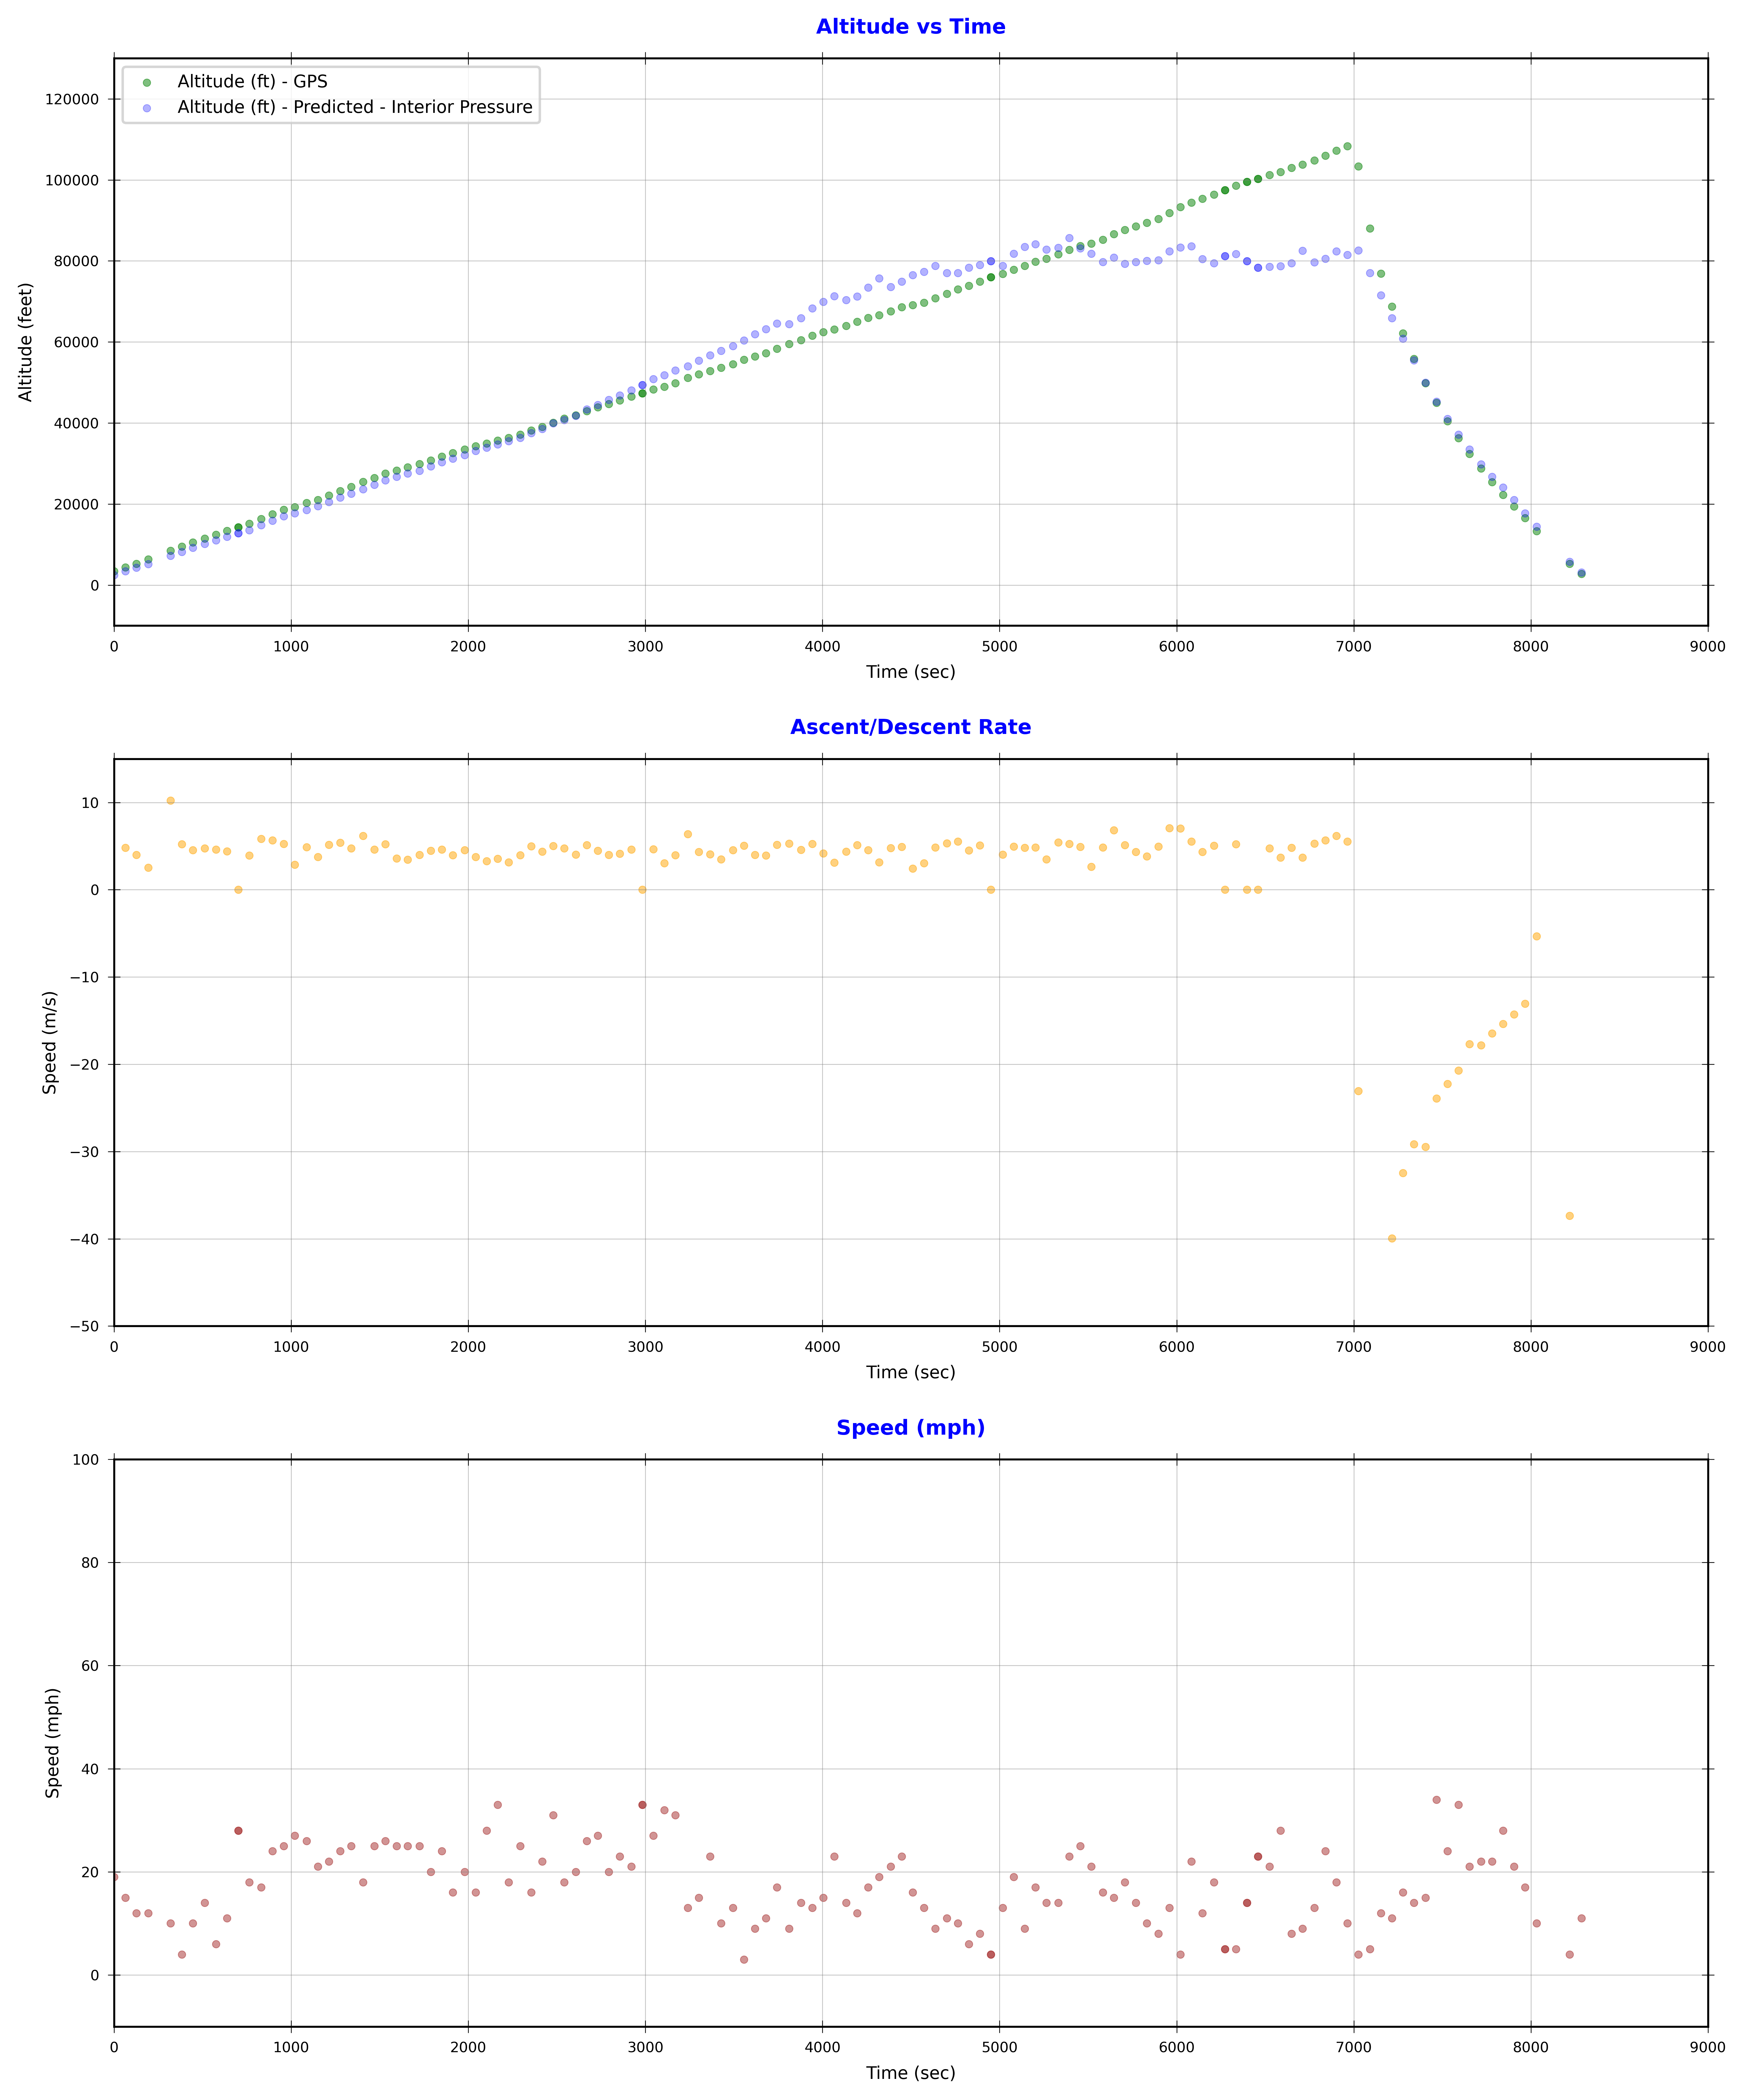

In [37]:
%matplotlib inline

plt.figure(dpi=600, figsize=(10,12))
plot1 = plt.subplot2grid((3,1),(0,0))
plot2 = plt.subplot2grid((3,1),(1,0))
plot3 = plt.subplot2grid((3,1),(2,0))

plot1.scatter('GPS Epoch', 'Altitude (ft)', data=df2, marker='.', color='green', cmap=plt.get_cmap("jet"), alpha=0.5, linewidth=0.3)
plot1.scatter('GPS Epoch', 'Predict IP Alt(ft)', data=df2, marker='.', color='blue', cmap=plt.get_cmap("jet"), alpha=0.3, linewidth=0.3)
plot1.tick_params(axis='both', which='both', reset=True, direction='inout', labelsize='xx-small', bottom=True, length=5, width=0.3, grid_color='grey', grid_alpha=0.5)
plot1.set_xlabel('Time (sec)', size='x-small')
plot1.set_ylabel('Altitude (feet)', size='x-small')
plot1.set_title('Altitude vs Time', color='blue', size='small', pad=10.0, weight='bold')
plot1.grid(visible=True, which='both', linewidth=0.3)
plot1.set_ylim([-10000,130000])
plot1.set_xlim([0,9000])
plot1.legend(['Altitude (ft) - GPS', 'Altitude (ft) - Predicted - Interior Pressure'], fontsize='x-small', loc='upper left')

plot2.scatter('GPS Epoch', 'Rate (mps)', data=df2, marker='.', color='orange', cmap=plt.get_cmap("jet"), alpha=0.5,linewidth=0.3)
plot2.tick_params(axis='both', which='both', reset=True, direction='inout', labelsize='xx-small', bottom=True, length=5, width=0.3, grid_color='grey', grid_alpha=0.5)
plot2.set_xlabel('Time (sec)', size='x-small')
plot2.set_ylabel('Speed (m/s)', size='x-small')
plot2.set_title('Ascent/Descent Rate', color='blue', size='small', pad=10.0, weight='bold')
plot2.grid(visible=True, which='both', linewidth=0.3)
plot2.set_ylim([-50,15])
plot2.set_xlim([0,9000])

plot3.scatter('GPS Epoch', 'Speed (mph)', data=df2, marker='.', color='brown', cmap=plt.get_cmap("jet"), alpha=0.5, linewidth=0.3)
plot3.tick_params(axis='both', which='both', reset=True, direction='inout', labelsize='xx-small', bottom=True, length=5, width=0.3, grid_color='grey', grid_alpha=0.5)
plot3.set_xlabel('Time (sec)', size='x-small')
plot3.set_ylabel('Speed (mph)', size='x-small')
plot3.set_title('Speed (mph)', color='blue', size='small', pad=10.0, weight='bold')
plot3.grid(visible=True, which='both', linewidth=0.3)
plot3.set_ylim([-10,100])
plot3.set_xlim([0,9000])

plt.tight_layout(pad=1.5)
plt.show()

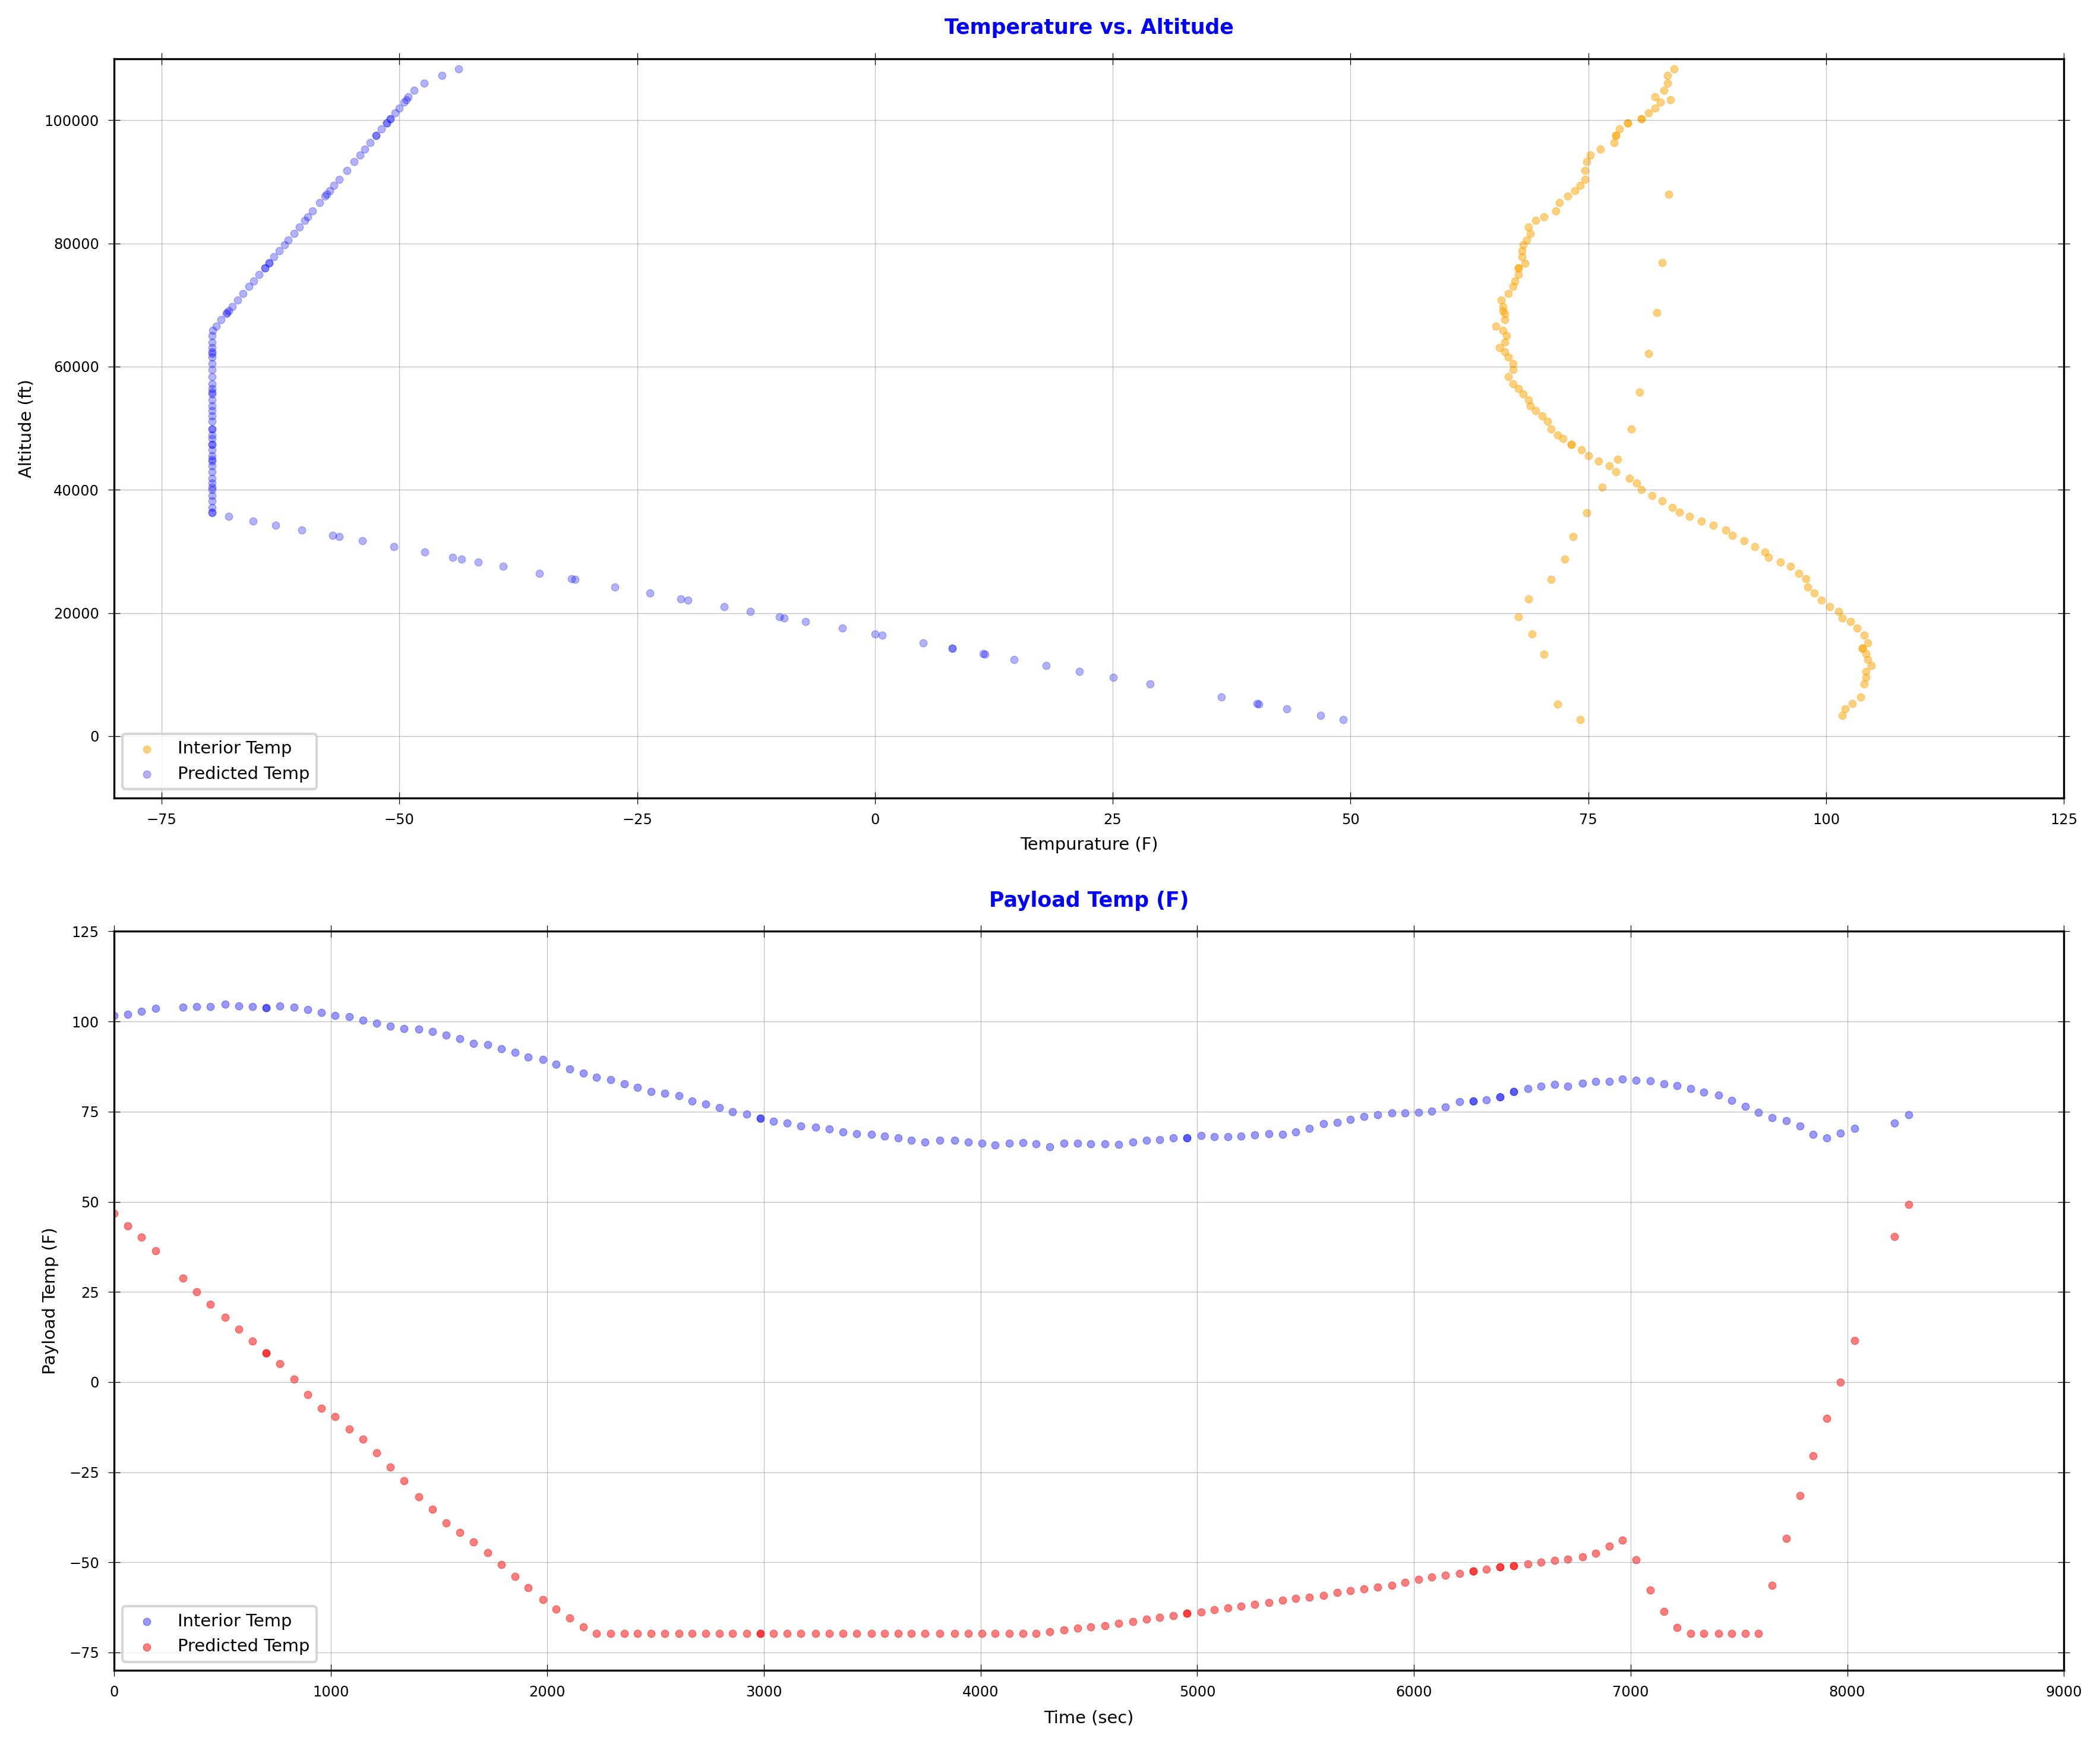

In [38]:
%matplotlib inline

plt.figure(dpi=300, figsize=(12,10))
plot4 = plt.subplot2grid((2,1),(0,0))
plot5 = plt.subplot2grid((2,1),(1,0))

plot4.scatter('Interior Temp (F)', 'Altitude (ft)', data=df2, marker='.', color='orange', cmap=plt.get_cmap("jet"), alpha=0.5, linewidth=0.3)
plot4.scatter('Predict Alt Temp(F)', 'Altitude (ft)', data=df2, marker='.', color='blue', cmap=plt.get_cmap("jet"), alpha=0.3, linewidth=0.3)
plot4.tick_params(axis='both', which='both', reset=True, direction='inout', labelsize='xx-small', bottom=True, length=5, width=0.3, grid_color='grey', grid_alpha=0.5)
plot4.set_xlabel('Tempurature (F)', size='x-small')
plot4.set_ylabel('Altitude (ft)', size='x-small')
plot4.set_title('Temperature vs. Altitude', color='blue', size='small', pad=10.0, weight='bold')
plot4.grid(visible=True, which='both', linewidth=0.3)
plot4.set_xlim([-80,125])
plot4.set_ylim([-10000,110000])
plot4.legend(['Interior Temp', 'Predicted Temp', 'Exterior Temp'], fontsize='x-small', loc='lower left')

plot5.scatter('GPS Epoch', 'Interior Temp (F)', data=df2, marker='.', color='blue', cmap=plt.get_cmap("jet"), alpha=0.4, linewidth=0.3)
plot5.scatter('GPS Epoch', 'Predict Alt Temp(F)', data=df2, marker='.', color='red', cmap=plt.get_cmap("jet"), alpha=0.5, linewidth=0.3)
plot5.tick_params(axis='both', which='both', reset=True, direction='inout', labelsize='xx-small', bottom=True, length=5, width=0.3, grid_color='grey', grid_alpha=0.5)
plot5.set_xlabel('Time (sec)', size='x-small')
plot5.set_ylabel('Payload Temp (F)', size='x-small')
plot5.set_title('Payload Temp (F)', color='blue', size='small', pad=10.0, weight='bold')
plot5.grid(visible=True, which='both', linewidth=0.3)
plot5.set_ylim([-80,125])
plot5.set_xlim([0,9000])
plot5.legend(['Interior Temp', 'Predicted Temp'], fontsize='x-small', loc='lower left')

plt.tight_layout(pad=1.5)
plt.show()

In [39]:
df2.columns

Index(['Date', 'Time', 'TZ', 'Path', 'HDOP', 'Interior Temp (C)',
       'Interior Pressure', 'Exterior Temp (C)', 'Exterior Pressure',
       'Humdity', 'Column11', 'Column12', 'Column13', 'Column14', 'Column15',
       'Column16', 'Column17', 'Column18', 'Column19', 'Column20', 'Column21',
       'Column22', 'Column23', 'Column24', 'Column25', 'Column26', 'Telemetry',
       'GPS Time', 'Lat', 'Lon', 'Bearing', 'Speed (mph)', 'Altitude (ft)',
       'Speed (kph)', 'Altitude (m)', 'HDOP (ft)', 'Interior Temp (F)',
       'I Pressure', 'Altitude Delta (ft)', 'Time Delta (s)', 'Rate (fps)',
       'Altitude Delta (m)', 'Rate (mps)', 'Cardinal Direction', 'GPS Epoch',
       'Predict Alt Pressure', 'Predict Alt Temp(C)', 'Predict Alt Temp(F)',
       'Predict IP Alt(m)', 'Predict IP Alt(ft)', 'Predict IP Temp(C)',
       'Predict IP Temp(F)'],
      dtype='object')

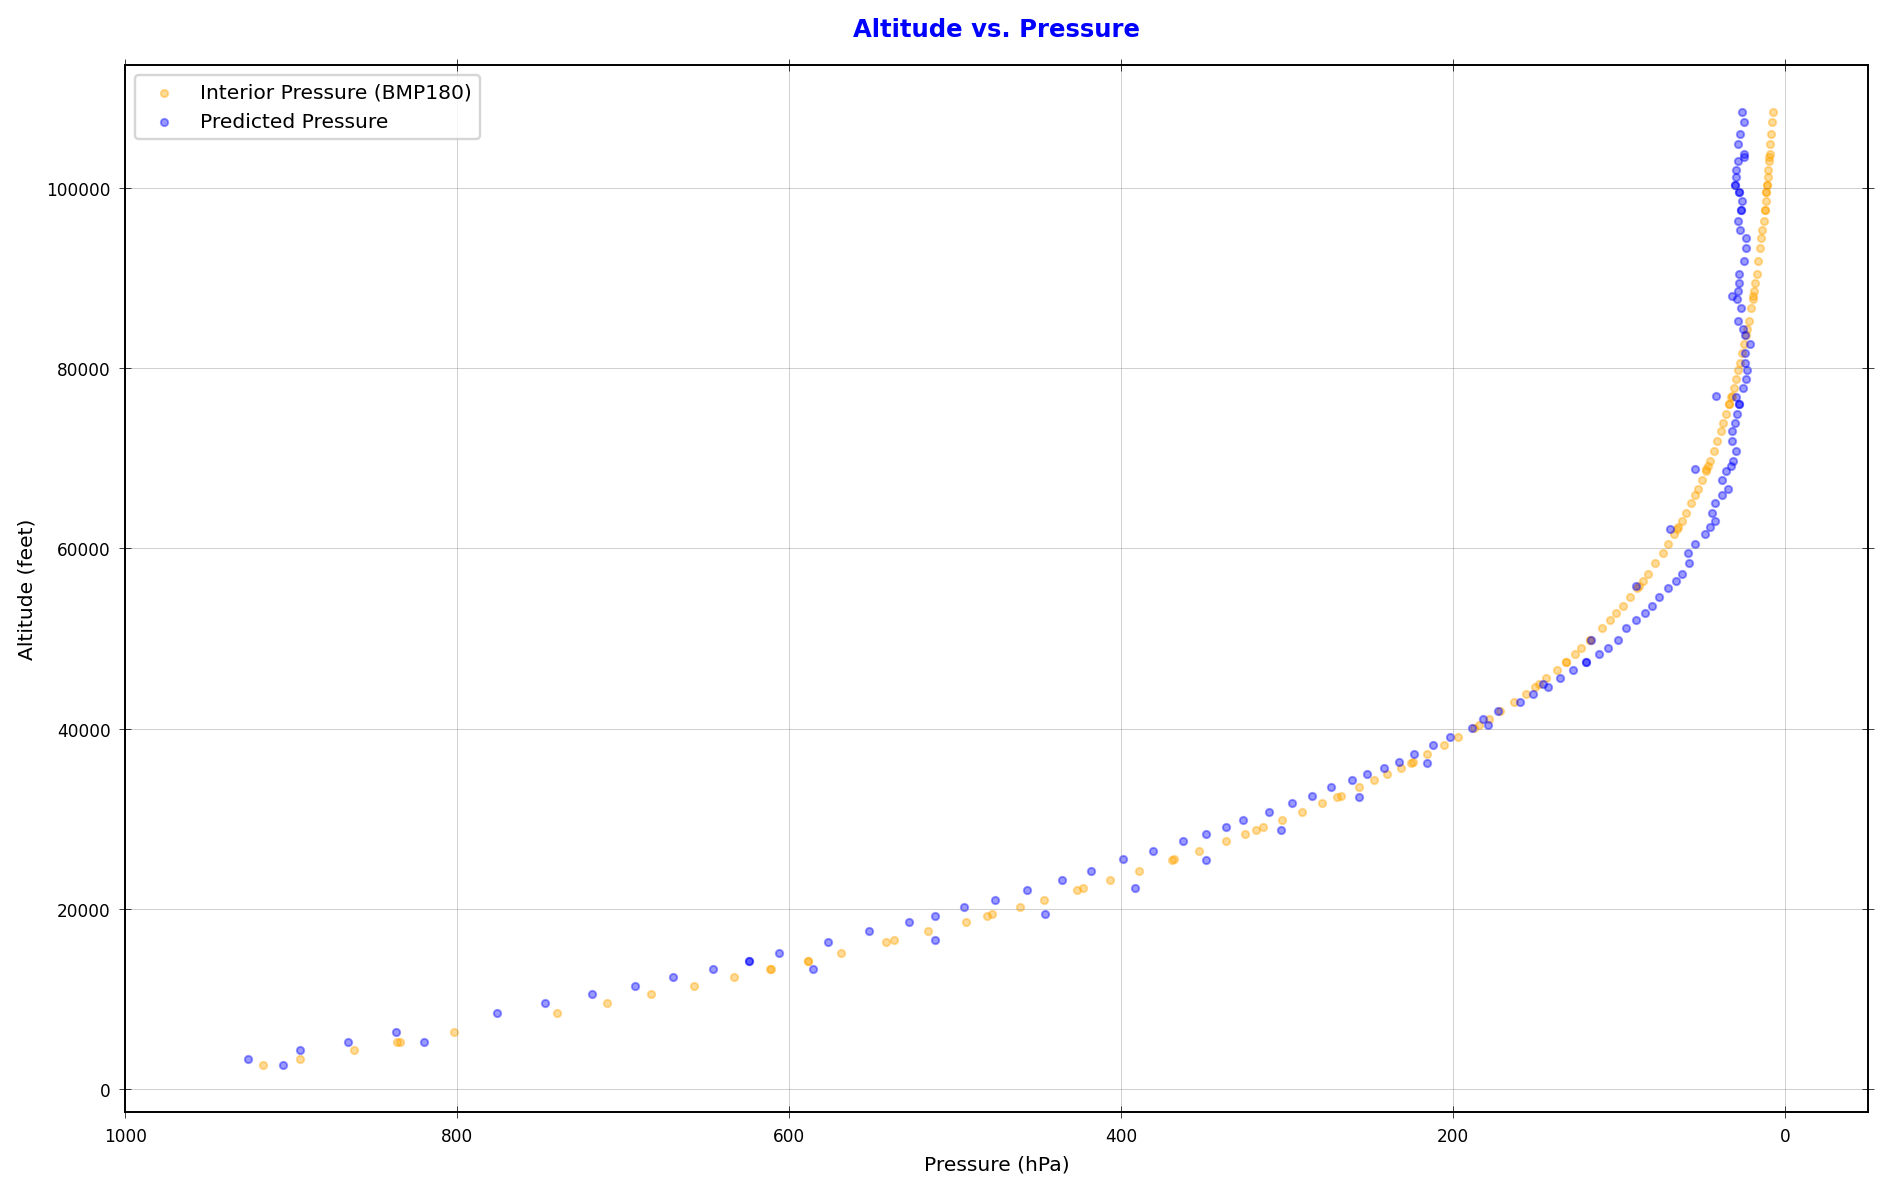

In [40]:
%matplotlib inline

plt.figure(dpi=175, figsize=(12,8))
plot1 = plt.subplot2grid((1,1),(0,0))

plot1.scatter('Predict Alt Pressure', 'Altitude (ft)', marker='.', data=df2, color='orange', alpha=0.4, linewidth=0.8)
plot1.scatter('I Pressure', 'Altitude (ft)', marker='.', data=df2, color='blue', alpha=0.4, linewidth=0.8)
plot1.tick_params(axis='both', which='both', reset=True, direction='inout', labelsize='x-small', bottom=True, length=5, width=0.3, grid_color='grey', grid_alpha=0.5)
plot1.set_xlabel('Pressure (hPa)', size='small')
plot1.set_ylabel('Altitude (feet)', size='small')
plot1.set_title('Altitude vs. Pressure', color='blue', fontsize='medium', weight='bold', pad=12.0)
plot1.grid(visible=True, which='both', linewidth=0.3)
plot1.legend(['Interior Pressure (BMP180)', 'Predicted Pressure'], fontsize='small', loc='upper left')
plot1.set_xlim([1000,-50])

plt.tight_layout(pad=5.0)
plt.show()

In [41]:
df2.columns

Index(['Date', 'Time', 'TZ', 'Path', 'HDOP', 'Interior Temp (C)',
       'Interior Pressure', 'Exterior Temp (C)', 'Exterior Pressure',
       'Humdity', 'Column11', 'Column12', 'Column13', 'Column14', 'Column15',
       'Column16', 'Column17', 'Column18', 'Column19', 'Column20', 'Column21',
       'Column22', 'Column23', 'Column24', 'Column25', 'Column26', 'Telemetry',
       'GPS Time', 'Lat', 'Lon', 'Bearing', 'Speed (mph)', 'Altitude (ft)',
       'Speed (kph)', 'Altitude (m)', 'HDOP (ft)', 'Interior Temp (F)',
       'I Pressure', 'Altitude Delta (ft)', 'Time Delta (s)', 'Rate (fps)',
       'Altitude Delta (m)', 'Rate (mps)', 'Cardinal Direction', 'GPS Epoch',
       'Predict Alt Pressure', 'Predict Alt Temp(C)', 'Predict Alt Temp(F)',
       'Predict IP Alt(m)', 'Predict IP Alt(ft)', 'Predict IP Temp(C)',
       'Predict IP Temp(F)'],
      dtype='object')

In [42]:
%matplotlib inline

plt.figure(dpi=800, figsize=(10,10))
plot1 = plt.subplot2grid((3,1),(0,0))
plot2 = plt.subplot2grid((3,1),(1,0))
plot3 = plt.subplot2grid((3,1),(2,0))

plot1.scatter('Altitude (ft)', 'HDOP (ft)', marker='.', data=df2, color='darkgreen', alpha=0.4, linewidth=0.8)
plot1.tick_params(axis='both', which='both', reset=True, direction='inout', labelsize='x-small', bottom=True, length=5, width=0.3, grid_color='grey', grid_alpha=0.5)
plot1.set_xlabel('Altitude (ft)', size='small')
plot1.set_ylabel('HDOP (ft)', size='small')
plot1.set_title('HDOP vs. Altitude', color='blue', fontsize='medium', weight='bold', pad=12.0)
plot1.grid(visible=True, which='both', linewidth=0.3)
plot1.set_ylim([0,700])
plot1.set_xlim([0,115000])

plot2.scatter('Speed (mph)', 'HDOP (ft)', marker='.', data=df2, color='darkgreen', alpha=0.4, linewidth=0.8)
plot2.tick_params(axis='both', which='both', reset=True, direction='inout', labelsize='x-small', bottom=True, length=5, width=0.3, grid_color='grey', grid_alpha=0.5)
plot2.set_xlabel('Speed (mph)', size='small')
plot2.set_ylabel('HDOP (ft)', size='small')
plot2.set_title('HDOP vs. Speed', color='blue', fontsize='medium', weight='bold', pad=12.0)
plot2.grid(visible=True, which='both', linewidth=0.3)
plot2.set_ylim([0,700])
plot2.set_xlim([0,50])

plot3.scatter('Rate (fps)', 'HDOP (ft)', marker='.', data=df2, color='orange', alpha=0.5, linewidth=0.8)
plot3.tick_params(axis='both', which='both', reset=True, direction='inout', labelsize='x-small', bottom=True, length=5, width=0.3, grid_color='grey', grid_alpha=0.5)
plot3.set_xlabel('Ascent/Descent Rate (fps)', size='small')
plot3.set_ylabel('HDOP (ft)', size='small')
plot3.set_title('HDOP vs. Rate', color='blue', fontsize='medium', weight='bold', pad=12.0)
plot3.grid(visible=True, which='both', linewidth=0.3)
plot3.set_ylim([0,700])
plot3.set_xlim([-300,75])

plt.tight_layout(pad=2.0)
plt.ion()
plt.show()

In [43]:
df2.columns

Index(['Date', 'Time', 'TZ', 'Path', 'HDOP', 'Interior Temp (C)',
       'Interior Pressure', 'Exterior Temp (C)', 'Exterior Pressure',
       'Humdity', 'Column11', 'Column12', 'Column13', 'Column14', 'Column15',
       'Column16', 'Column17', 'Column18', 'Column19', 'Column20', 'Column21',
       'Column22', 'Column23', 'Column24', 'Column25', 'Column26', 'Telemetry',
       'GPS Time', 'Lat', 'Lon', 'Bearing', 'Speed (mph)', 'Altitude (ft)',
       'Speed (kph)', 'Altitude (m)', 'HDOP (ft)', 'Interior Temp (F)',
       'I Pressure', 'Altitude Delta (ft)', 'Time Delta (s)', 'Rate (fps)',
       'Altitude Delta (m)', 'Rate (mps)', 'Cardinal Direction', 'GPS Epoch',
       'Predict Alt Pressure', 'Predict Alt Temp(C)', 'Predict Alt Temp(F)',
       'Predict IP Alt(m)', 'Predict IP Alt(ft)', 'Predict IP Temp(C)',
       'Predict IP Temp(F)'],
      dtype='object')

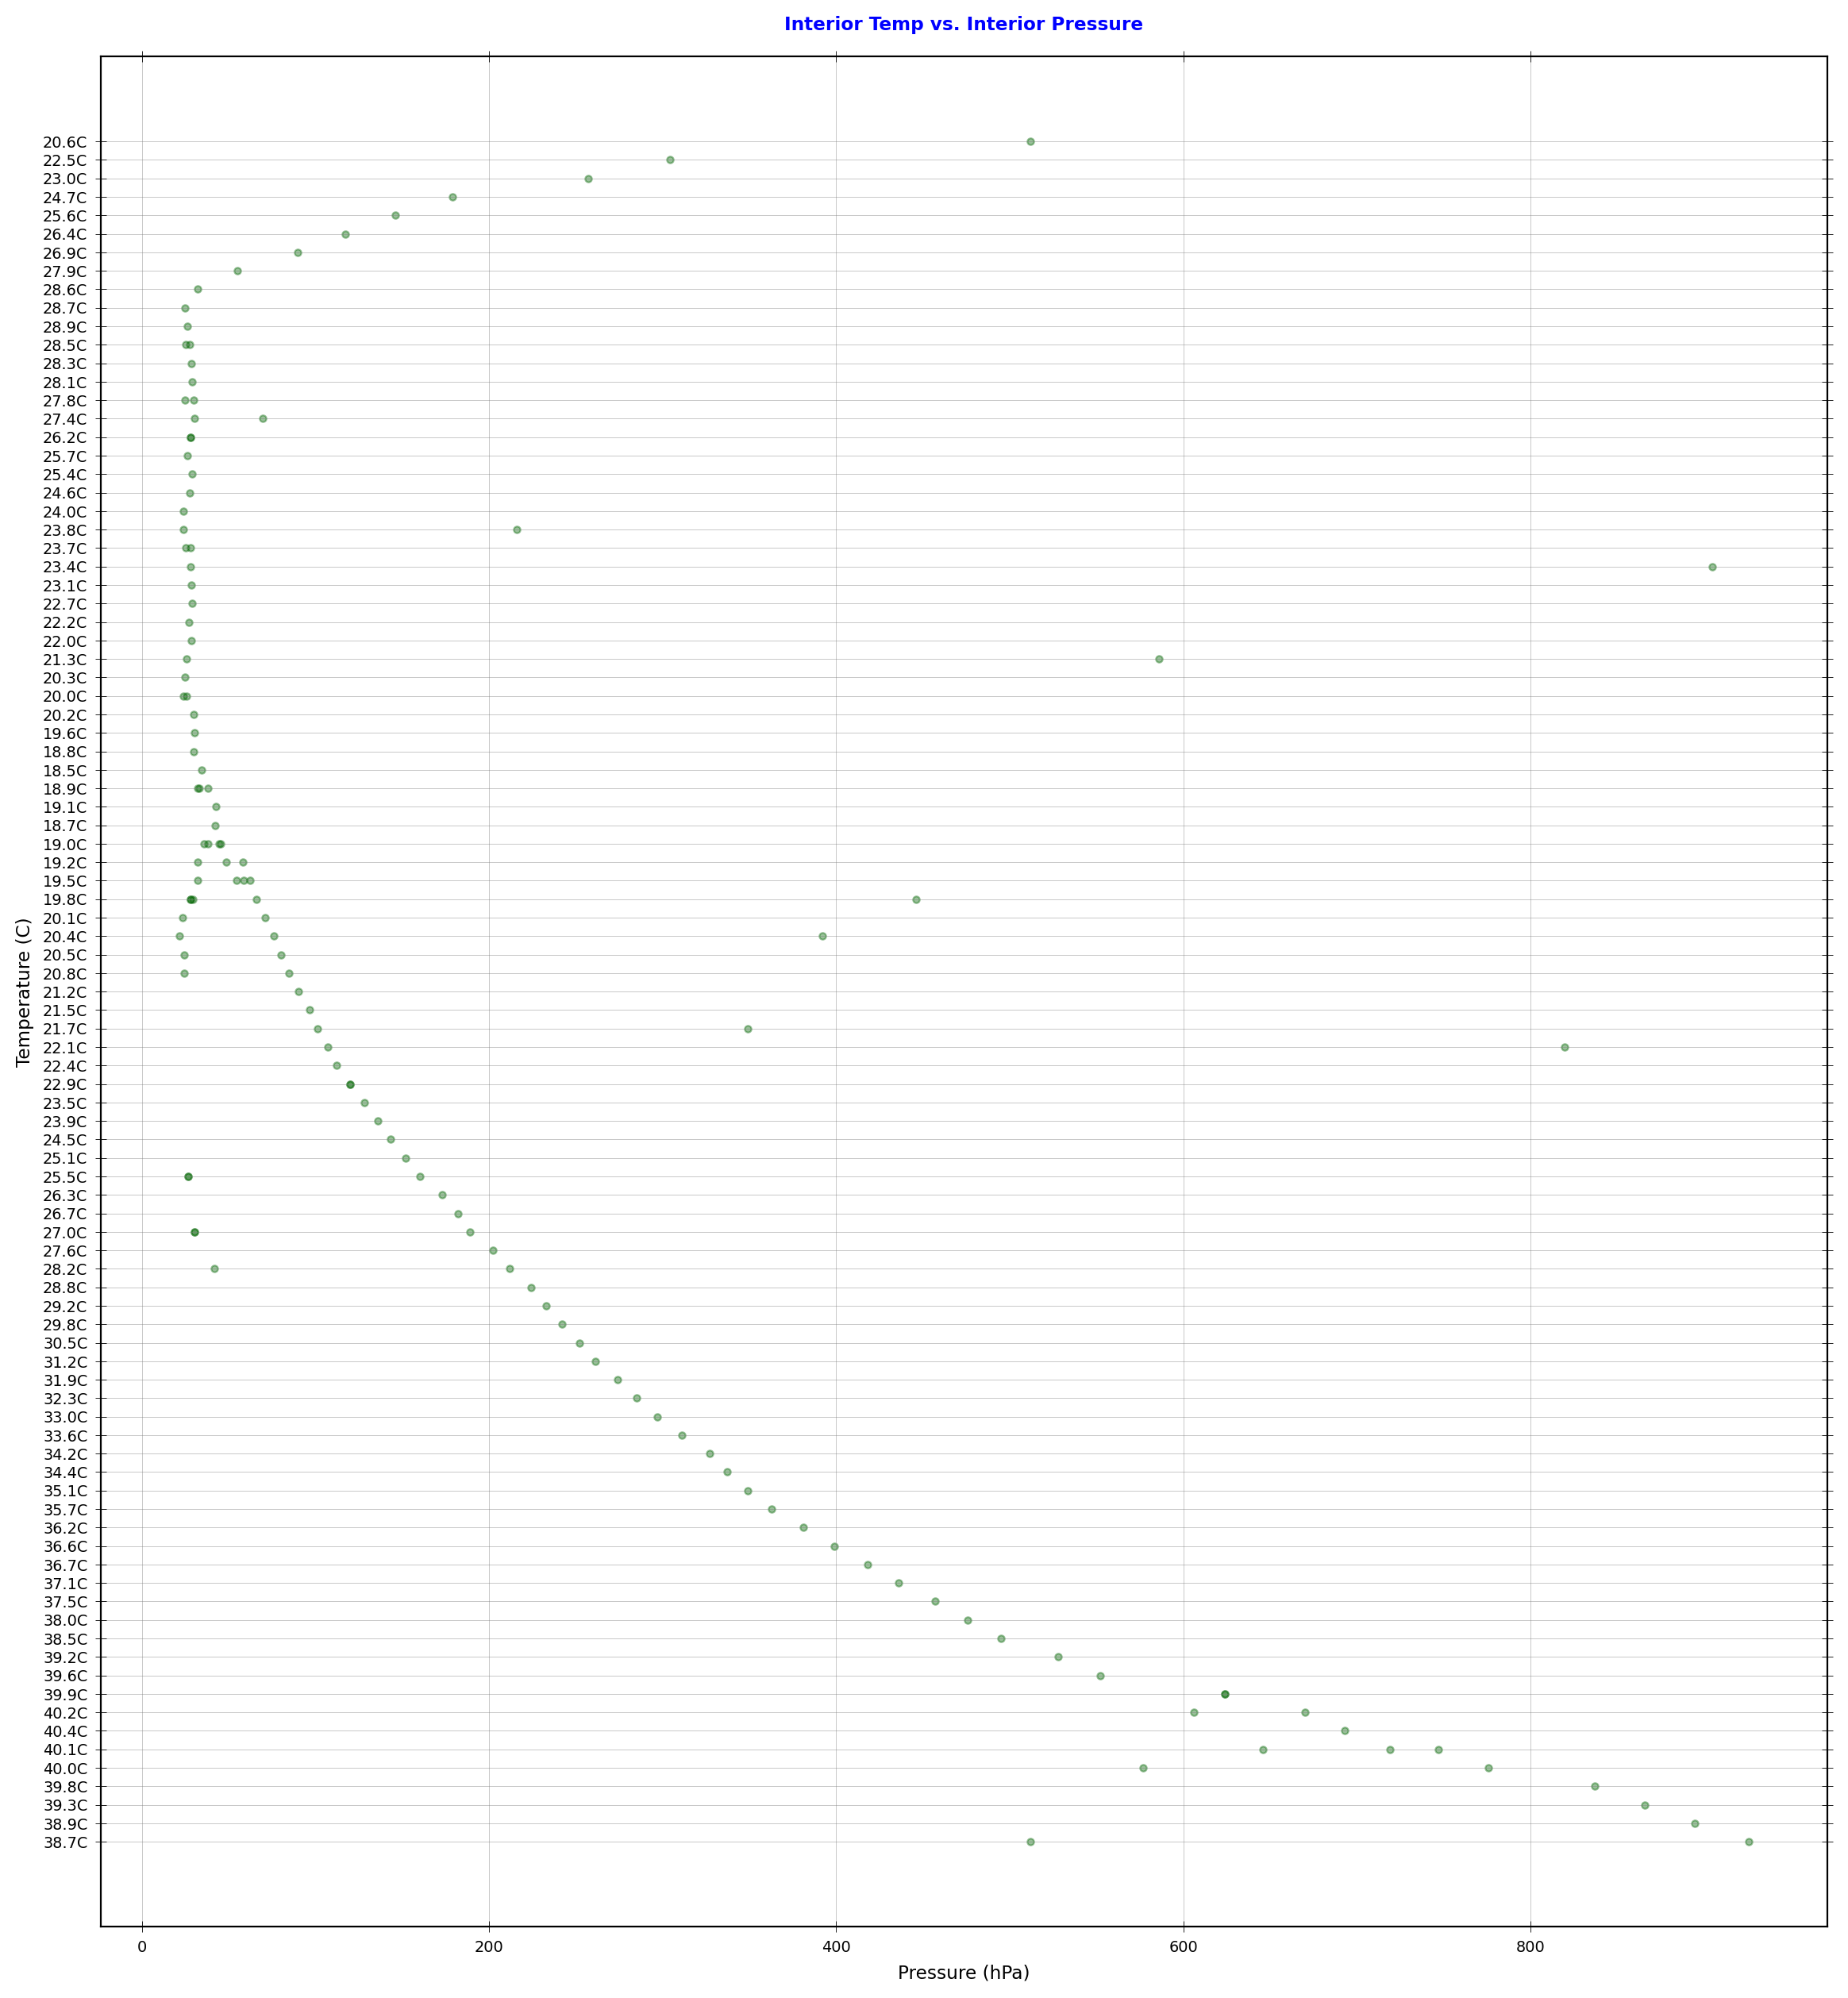

In [44]:
%matplotlib inline

plt.figure(dpi=200, figsize=(12,25))
plot1 = plt.subplot2grid((2,1),(0,0))

plot1.scatter('I Pressure', 'Interior Temp (C)', marker='.', data=df2, color='darkgreen', alpha=0.4, linewidth=0.8)
plot1.tick_params(axis='both', which='both', reset=True, direction='inout', labelsize='x-small', bottom=True, length=5, width=0.3, grid_color='grey', grid_alpha=0.5)
plot1.set_xlabel('Pressure (hPa)', size='small')
plot1.set_ylabel('Temperature (C)', size='small')
plot1.set_title('Interior Temp vs. Interior Pressure', color='blue', fontsize='small', weight='bold', pad=12.0)
plot1.grid(visible=True, which='both', linewidth=0.3)

plt.tight_layout(pad=2.0)
plt.ion()
plt.show()

In [45]:
df2.columns

Index(['Date', 'Time', 'TZ', 'Path', 'HDOP', 'Interior Temp (C)',
       'Interior Pressure', 'Exterior Temp (C)', 'Exterior Pressure',
       'Humdity', 'Column11', 'Column12', 'Column13', 'Column14', 'Column15',
       'Column16', 'Column17', 'Column18', 'Column19', 'Column20', 'Column21',
       'Column22', 'Column23', 'Column24', 'Column25', 'Column26', 'Telemetry',
       'GPS Time', 'Lat', 'Lon', 'Bearing', 'Speed (mph)', 'Altitude (ft)',
       'Speed (kph)', 'Altitude (m)', 'HDOP (ft)', 'Interior Temp (F)',
       'I Pressure', 'Altitude Delta (ft)', 'Time Delta (s)', 'Rate (fps)',
       'Altitude Delta (m)', 'Rate (mps)', 'Cardinal Direction', 'GPS Epoch',
       'Predict Alt Pressure', 'Predict Alt Temp(C)', 'Predict Alt Temp(F)',
       'Predict IP Alt(m)', 'Predict IP Alt(ft)', 'Predict IP Temp(C)',
       'Predict IP Temp(F)'],
      dtype='object')

In [46]:
df2.head(5)

Date      Time    TZ                                     Path    HDOP   
1 2022-05-13  13:48:09  CDT:  KW9D-12>APLIGA,N9ULL*,WIDE2,qAR,N9NWI-1  00103H  \
2 2022-05-13  13:49:12  CDT:  KW9D-12>APLIGA,N9ULL*,WIDE2,qAR,N9NWI-1  00110H   
3 2022-05-13  13:50:15  CDT:  KW9D-12>APLIGA,N9ULL*,WIDE2,qAR,N9NWI-1  00109H   
5 2022-05-13  13:51:22  CDT:      KW9D-12>APLIGA,WIDE2-1,qAR,K9WRA-11  00089H   
6 2022-05-13  13:53:28  CDT:      KW9D-12>APLIGA,WIDE2-1,qAR,KC8RFE-3  00094H   

  Interior Temp (C) Interior Pressure Exterior Temp (C) Exterior Pressure   
1             38.7C           926.hPa             0.00C           0.00hPa  \
2             38.9C           895.hPa             0.00C           0.00hPa   
3             39.3C           866.hPa             0.00C           0.00hPa   
5             39.8C           837.hPa             0.00C           0.00hPa   
6             40.0C           776.hPa             0.00C           0.00hPa   

  Humdity  ... Rate (mps) Cardinal Direction GPS Epoch Predict Alt Pressure   
1    0.00  ...        NaN                NNE         0           894.513762  \
2    0.00  ...   4.804229                 NE        63           862.141724   
3    0.00  ...   4.003343                  E       126           834.255039   
5    0.00  ...   2.542419                 SE       193           801.914168   
6    0.00  ...  10.208381                SSE       319           740.057835   

   Predict Alt Temp(C) Predict Alt Temp(F)  Predict IP Alt(m)   
1             8.247193           46.844947         753.097751  \
2             6.280598           43.305076        1034.585353   
3             4.537951           40.168312        1305.176424   
5             2.456869           36.422365        1583.231173   
6            -1.720503           28.903095        2194.648522   

   Predict IP Alt(ft) Predict IP Temp(C) Predict IP Temp(F)  
1         2470.793151          10.105444          50.189800  
2         3394.308906           8.276290          46.897321  
3         4282.074889           6.518095          43.732571  
5         5194.328005           4.711560          40.480808  
6         7200.290436           0.739708          33.331474  

[5 rows x 52 columns]

In [47]:
df2['Lat_DD'] = df2['Lat'].apply(convert_lat_gps_coord)

In [48]:
df2['Lon_DD'] = df2['Lon'].apply(convert_lon_gps_coord)

In [49]:
df2.tail(5)

Date      Time    TZ                                         Path   
160 2022-05-13  15:59:54  CDT:          KW9D-12>APLIGA,WIDE2-1,qAR,K9WRA-11  \
161 2022-05-13  16:00:56  CDT:          KW9D-12>APLIGA,WIDE2-1,qAR,K9WRA-11   
163 2022-05-13  16:02:02  CDT:          KW9D-12>APLIGA,WIDE2-1,qAR,K9WRA-11   
164 2022-05-13  16:05:08  CDT:          KW9D-12>APLIGA,WIDE2-1,qAR,K9WRA-11   
166 2022-05-13  16:06:14  CDT:  KW9D-12>APLIGA,WIDE1-1,WIDE2-1,qAR,K9WRA-11   

       HDOP Interior Temp (C) Interior Pressure Exterior Temp (C)   
160  00136H             19.8C           446.hPa             0.00C  \
161  00140H             20.6C           512.hPa             0.00C   
163  00139H             21.3C           586.hPa             0.00C   
164  00139H             22.1C           820.hPa             0.00C   
166  00175H             23.4C           905.hPa             0.00C   

    Exterior Pressure Humdity  ... GPS Epoch Predict Alt Pressure   
160           0.00hPa    0.00  ...      7905           478.075452  \
161           0.00hPa    0.00  ...      7967           537.023545   
163           0.00hPa    0.00  ...      8033           611.906835   
164           0.00hPa    0.00  ...      8219           836.038844   
166           0.00hPa    0.00  ...      8285           916.840997   

    Predict Alt Temp(C) Predict Alt Temp(F)  Predict IP Alt(m)   
160          -23.373853          -10.072935        6414.560151  \
161          -17.786598           -0.015876        5403.745036   
163          -11.364826           11.543314        4389.288903   
164            4.650823           40.371481        1749.887392   
166            9.570244           49.226440         942.929105   

    Predict IP Alt(ft)  Predict IP Temp(C)  Predict IP Temp(F)     Lat_DD   
160       21045.144883          -26.652610          -15.974697  40.801389  \
161       17728.822322          -20.094510           -4.170117  40.810000   
163       14400.554164          -13.510691            7.680755  40.817222   
164        5741.100377            3.628862           38.531952  40.820000   
166        3093.599429            8.871870           47.969366  40.822500   

        Lon_DD  
160 -89.336944  
161 -89.339167  
163 -89.340556  
164 -89.339444  
166 -89.333889  

[5 rows x 54 columns]

In [ ]:
# Drop last row since it's invalid
# df2.drop(df2.tail(1).index,inplace=True)

In [ ]:
df2.tail(5)

In [50]:
mid = int(len(df2['Lon_DD'])/2)

In [51]:
scl = [0,"rgb(150,0,90)"],[0.125,"rgb(0, 0, 200)"],[0.25,"rgb(0, 25, 255)"],\
[0.375,"rgb(0, 152, 255)"],[0.5,"rgb(44, 255, 150)"],[0.625,"rgb(151, 255, 0)"],\
[0.75,"rgb(255, 234, 0)"],[0.875,"rgb(255, 111, 0)"],[1,"rgb(255, 0, 0)"]

In [52]:
fig = go.Figure(go.Scattermapbox(
    name = 'Flight Path',
    mode = "markers+lines",
    lon = df2['Lon_DD'],
    lat = df2['Lat_DD'],
    hoverinfo = 'lon+lat',
    hovertemplate =
    "Longitude: %{lon}<br>" +
    "Latitude: %{lat}<br>" + 
    "%{text}",
    text = 'Altitude: ' + df2['Altitude (ft)'].astype(str) + ' (ft)<br>Speed:' + df2['Speed (mph)'].astype(str) +  '<br>Int Temp: ' + df2['Interior Temp (C)'].astype(str) + '<br>Int Pressure: ' + df2['Interior Pressure'].astype(str),
    marker = dict(
        size = 7,
        opacity = 1.0,
        symbol = 'circle',    
        reversescale = False,
        autocolorscale = False,
        colorscale = scl,
        cmin = 0,
        color = df2['Altitude (ft)'], 
        cmax = df2['Altitude (ft)'].max(),
        colorbar_title="<b>High Altitude Balloon</b><br>April 21st 2023")))

In [53]:
fig.update_layout(
    height = 750,
    width = 1500,
    margin ={'l':10,'t':50,'b':10,'r':10},
    mapbox = {
        'center': {'lon': df2['Lon_DD'].iloc[mid], 'lat': df2['Lat_DD'].iloc[mid]},
        'style': "stamen-terrain",
        'zoom': 9.5,
        })

fig.update_layout(
        title = '<b>High Altitude Balloon - Flight Path & Altitude</b>',
        geo_scope='usa',
        geo = dict(
            scope = 'north america',
            showland = True,
            landcolor = "rgb(212, 212, 212)",
            subunitcolor = "rgb(255, 255, 255)",
            countrycolor = "rgb(255, 255, 255)",
            showlakes = True,
            lakecolor = "rgb(255, 255, 255)",
            showsubunits = True,
            showcountries = True,
            resolution = 50,
            projection = dict(
                type = 'conic conformal',
                rotation_lon = -100
            ),
            lonaxis = dict(
                showgrid = True,
                gridwidth = 0.5,
                range= [ -140.0, -55.0 ],
                dtick = 5
            ),
            lataxis = dict (
                showgrid = True,
                gridwidth = 0.5,
                range= [ 20.0, 60.0 ],
                dtick = 5
            )
        ),
        hoverlabel=dict(
            bgcolor="white",
            font_size=14,
            font_family="Arial"
        ),
    )

fig.show()